In [20]:
import tensorflow as tf
import numpy as np # linear algebra
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import col

In [22]:
# Replace 'tfrecord_directory' with the path to your directory containing TFRecord files
tfrecord_directory = "*.tfrecord"

vid_ids = []
labels = []

# Define the function to parse a single TFRecord example
def parse_tfrecord_fn(example):
    feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.VarLenFeature(tf.int64),
        # Add other features as needed
    }
    example = tf.io.parse_single_example(example, feature_description)

    def decode_id(tensor):
        return tensor.numpy().decode('UTF-8')

    def decode_labels(tensor):
        return tf.sparse.to_dense(tensor, default_value=0).numpy().tolist()

    vid_id = tf.py_function(func=decode_id, inp=[example['id']], Tout=tf.string)
    label = tf.py_function(func=decode_labels, inp=[example['labels']], Tout=tf.int64)

    return vid_id, label

# Get a list of TFRecord files in the directory
tfrecord_files = tf.io.gfile.glob(tfrecord_directory)

# Iterate over TFRecord files
for file_path in tfrecord_files:
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(file_path)

    # Map the parse function to each element in the dataset
    parsed_dataset = dataset.map(parse_tfrecord_fn)

    # Iterate over the parsed dataset and extract ids and labels
    for vid_id, label in parsed_dataset:
        vid_ids.append(vid_id.numpy().decode('UTF-8'))
        labels.append(label.numpy())

# Convert each element from numpy.int64 to int
labels = [int(label) for label in labels]

In [3]:
from pyspark.sql.types import StringType, IntegerType, StructType, StructField

# Initialize Spark session
spark = SparkSession.builder.appName("example").getOrCreate()


# Create a list of tuples from the two lists
data = list(zip(vid_ids, labels))

# Define the schema for the DataFrame
schema = StructType([
    StructField("vid_id", StringType(), True),
    StructField("label", StringType(), True)
])

# Create a DataFrame from the list of tuples and the schema
df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame
df.show(truncate=False)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 19:07:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+-----+
|vid_id|label|
+------+-----+
|lKbF  |1    |
|HebF  |3    |
|GkbF  |66   |
|q2bF  |14   |
|aUbF  |141  |
|A9bF  |2    |
|52bF  |25   |
|gNbF  |2    |
|6ZbF  |1    |
|rubF  |39   |
|UqbF  |11   |
|ATbF  |0    |
|3lbF  |39   |
|UGbF  |3    |
|oJbF  |0    |
|exbF  |12   |
|CFbF  |39   |
|CsbF  |3    |
|pUbF  |0    |
|DLbF  |333  |
+------+-----+
only showing top 20 rows



In [4]:
# Group by the 'label' column and count occurrences
label_counts = df.groupBy("label").count()

# Sort the results in descending order by count
sorted_label_counts = label_counts.sort(col("count").desc())

# Show the top 10
sorted_label_counts.show(10)

+-----+-----+
|label|count|
+-----+-----+
|    0|  201|
|    2|  110|
|    3|  107|
|    5|   40|
|   11|   36|
|    4|   30|
|   14|   29|
|    8|   25|
|   15|   21|
|    6|   17|
+-----+-----+
only showing top 10 rows



In [5]:
# Read the CSV file into a DataFrame
vocabulary_df = spark.read.csv("vocabulary.csv", header=True, inferSchema=True)

# Show the DataFrame
vocabulary_df.toPandas()

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,None,None,A concert is a live music performance in front...
1,7,200813,/m/0k4j,Car,https://en.wikipedia.org/wiki/Car,Autos & Vehicles,None,None,"A car is a wheeled, self-powered motor vehicle..."
2,8,181579,/m/026bk,Dance,https://en.wikipedia.org/wiki/Dance,Arts & Entertainment,None,None,Dance is a performance art form consisting of ...
3,11,135357,/m/02wbm,Food,https://en.wikipedia.org/wiki/Food,Food & Drink,None,None,Food is any substance consumed to provide nutr...
4,12,130835,/m/02vx4,Association football,https://en.wikipedia.org/wiki/Association_foot...,Sports,None,None,"Association football, more commonly known as f..."
...,...,...,...,...,...,...,...,...,...
995,1781,502,/m/0d5gx,Castle,https://en.wikipedia.org/wiki/Castle,Arts & Entertainment,Reference,None,A castle is a type of fortified structure buil...
996,1769,502,/m/01xf5,Clutch,https://en.wikipedia.org/wiki/Clutch,Autos & Vehicles,None,None,A clutch is a mechanical device that engages a...
997,1805,502,/m/02yvhj,School bus,https://en.wikipedia.org/wiki/School_bus,Travel,None,None,A school bus is a type of bus used for student...
998,1788,500,/m/05ngn6,Zero (Mega Man),https://en.wikipedia.org/wiki/Zero_(Mega_Man),Games,None,None,"""Zero is a video game character present throug..."


In [7]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a new column 'labelindex' to vocabulary_df containing the index values
vocabulary_df = vocabulary_df.withColumn("labelindex", monotonically_increasing_id())

# Join the label_counts_df with vocabulary_df based on the 'label' column
joined_df = sorted_label_counts.join(vocabulary_df, col("label") == col("labelindex"), "inner")

# Select the columns of interest
result_df = joined_df.select("label", "count", "Name")

result_df= result_df.sort(col("count").desc())
# Show the top 10 results
result_df.show(10, truncate=False)

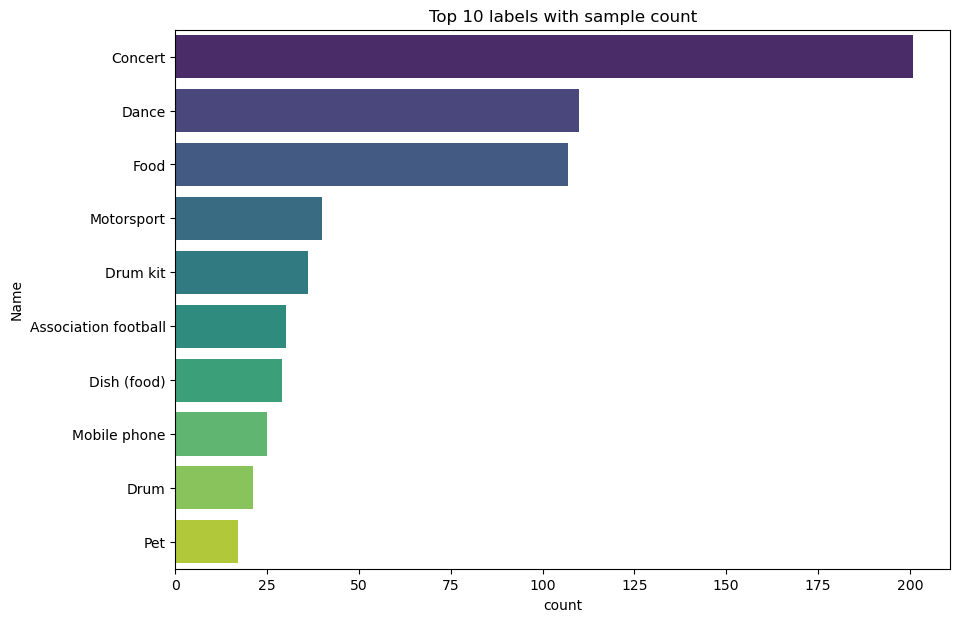

In [9]:
# Select the top 10 rows
top_n_result = result_df.limit(10)

# If you want to visualize the results with Matplotlib and Seaborn, you can collect the data to the driver
# (Note: Only do this if the data is small enough to fit in memory on the driver)
local_top_n_result = top_n_result.toPandas()

# Now, you can use Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a Seaborn color palette (e.g., "viridis", "magma", "coolwarm", etc.)
# You can find more palettes here: https://seaborn.pydata.org/tutorial/color_palettes.html
color_palette = "viridis"

# Create a barplot using Seaborn with the specified color palette
plt.figure(figsize=(10, 7))
sns.barplot(x='count', y='Name', data=local_top_n_result, palette=color_palette, hue='Name', dodge=False, legend=False)
plt.title('Top {} labels with sample count'.format(10))
plt.show()

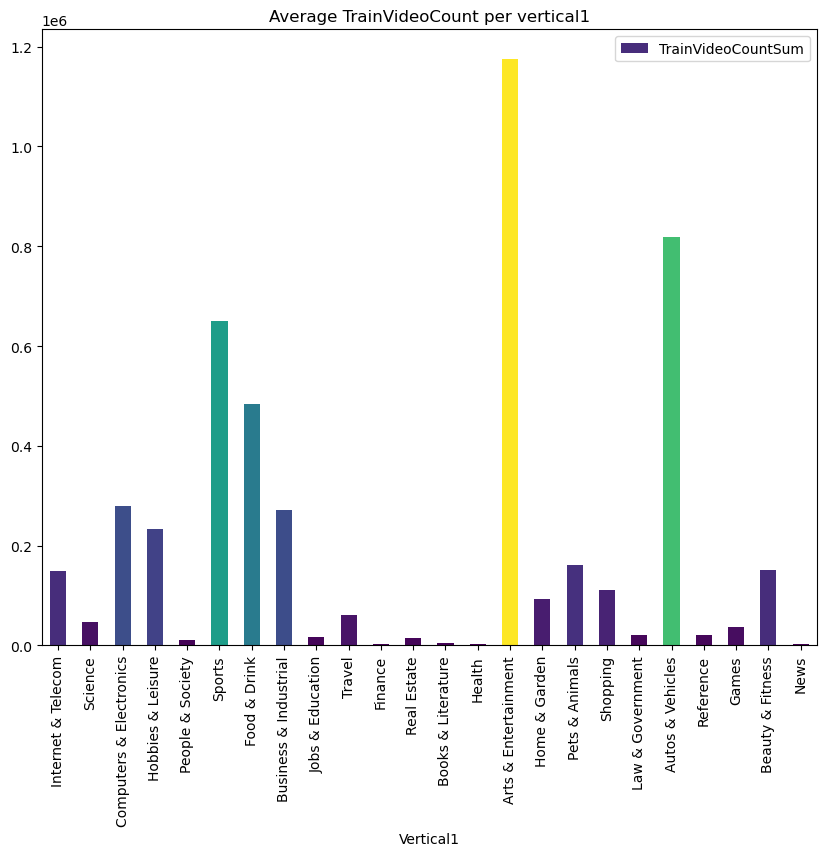

In [23]:
from pyspark.sql import functions as F

# Group by 'Vertical1' and calculate the sum of 'TrainVideoCount' for each group
train_video_count_sum = vocabulary_df.groupBy('Vertical1').agg(F.sum('TrainVideoCount').alias('TrainVideoCountSum'))

# Plot the result using the collect() method to bring the data to the driver
train_video_count_sum_pandas = train_video_count_sum.toPandas()

# Set a color for each bar
colors = plt.cm.viridis(train_video_count_sum_pandas['TrainVideoCountSum'] / train_video_count_sum_pandas['TrainVideoCountSum'].max())

# Plot the bar chart with specified colors
train_video_count_sum_pandas.plot(kind='bar', x='Vertical1', y='TrainVideoCountSum', figsize=(10, 8), color=colors)
plt.title("Average TrainVideoCount per vertical1")
plt.savefig('countpervert1.png', dpi=300, bbox_inches='tight')
plt.show()

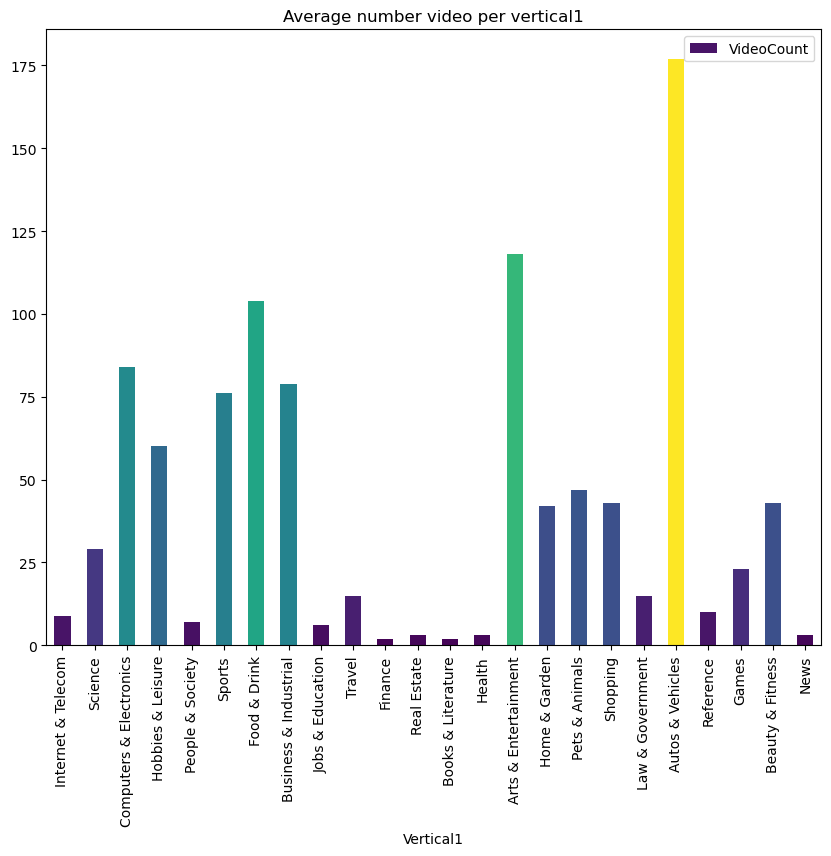

In [24]:
# Group by 'Vertical1' and calculate the count of rows for each group
video_count = vocabulary_df.groupBy('Vertical1').agg(F.count('*').alias('VideoCount'))

# Plot the result using the collect() method to bring the data to the driver
video_count_pandas = video_count.toPandas()

# Set a color for each bar
colors = plt.cm.viridis(video_count_pandas['VideoCount'] / video_count_pandas['VideoCount'].max())

# Plot the bar chart with specified colors
video_count_pandas.plot(kind='bar', x='Vertical1', y='VideoCount', figsize=(10, 8), color=colors)
plt.title("Average number video per vertical1")
plt.savefig('countpervert2.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Filter and transform the DataFrame
filtered_df = vocabulary_df.filter(
    ((F.col('Vertical1') != 'NaN') & (F.col('Vertical2') != 'NaN') & (F.col('Vertical1') != '') & (F.col('Vertical2') != '') & (F.col('Vertical1') != F.col('Vertical2')))
    | ((F.col('Vertical1') != 'NaN') & (F.col('Vertical3') != 'NaN') & (F.col('Vertical1') != '') & (F.col('Vertical3') != '') & (F.col('Vertical1') != F.col('Vertical3')))
    | ((F.col('Vertical2') != 'NaN') & (F.col('Vertical3') != 'NaN') & (F.col('Vertical2') != '') & (F.col('Vertical3') != '') & (F.col('Vertical2') != F.col('Vertical3')))
)

# Extract the required columns and convert to Pandas for further processing
edges_df = filtered_df.select('Vertical1', 'Vertical2', 'Vertical3').toPandas()

# Create a list of tuples
T1 = [(row['Vertical1'], row['Vertical2']) for _, row in edges_df.iterrows()]
T1 += [(row['Vertical1'], row['Vertical3']) for _, row in edges_df.iterrows()]
T1 += [(row['Vertical2'], row['Vertical3']) for _, row in edges_df.iterrows()]

# Count occurrences of each tuple
edges = {k: T1.count(k) for k in set(T1)}
print("List =", len(edges), "elements")
edges

List = 88 elements


{('Beauty & Fitness', 'Home & Garden'): 2,
 ('Arts & Entertainment', 'People & Society'): 4,
 ('Autos & Vehicles', 'Travel'): 1,
 ('Internet & Telecom', None): 15,
 ('Hobbies & Leisure', 'Law & Government'): 1,
 ('Hobbies & Leisure', 'Sports'): 6,
 ('News', None): 8,
 ('Computers & Electronics', 'News'): 2,
 ('Computers & Electronics', 'Games'): 5,
 ('Business & Industrial', 'Reference'): 1,
 ('Business & Industrial', 'Law & Government'): 1,
 ('Computers & Electronics', None): 22,
 ('Hobbies & Leisure', None): 22,
 ('Arts & Entertainment', 'Shopping'): 3,
 ('Autos & Vehicles', 'Sports'): 3,
 ('People & Society', 'Reference'): 1,
 ('Beauty & Fitness', 'Hobbies & Leisure'): 1,
 ('Science', None): 26,
 ('Business & Industrial', 'Pets & Animals'): 2,
 ('Real Estate', None): 1,
 ('Law & Government', None): 5,
 ('Beauty & Fitness', None): 6,
 ('Autos & Vehicles', 'News'): 2,
 ('Business & Industrial', 'Travel'): 7,
 ('Books & Literature', None): 3,
 ('Arts & Entertainment', 'Science'): 1,
 (